### Imports

In [37]:
from mpl_toolkits import mplot3d
from sklearn.metrics import silhouette_score
from sklearn.model_selection import RandomizedSearchCV
from tqdm import tqdm
from utils.utils import *

import hdbscan
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import sys


%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 2.37 ms (started: 2023-05-18 20:25:58 -05:00)


### Edge embeddings

In [66]:
dir = os.path.dirname(os.getcwd())
print(dir)

method = ["dgi", "vgae"]
method = method[1]
print("Method:\t\t", method)

group = [("WT", 5), ("zwf1^", 3), ("pck1^", 2)]
group = group[0]
print("Group:\t\t", group)

subgroups = [str(k + 1) for k in range(group[1])]
print("Subgroup:\t", subgroups)

dimensions = [3] # [2, 4, 8, 16, 32, 64, 128, 256]
print("Dimensions:\t", dimensions)

/home/ealvarez/Project/GNN_Filter
Method:		 vgae
Group:		 ('WT', 5)
Subgroup:	 ['1', '2', '3', '4', '5']
Dimensions:	 [3]
time: 1.9 ms (started: 2023-05-18 22:25:25 -05:00)


In [39]:
# Get edges embeddings

for dimension in tqdm(dimensions):
    # Get embeddings    
    for i in tqdm(subgroups):
        # Read dataset
        df_node_embeddings = pd.read_csv("{}/output_{}/node_embeddings/{}_node-embeddings_{}_{}.csv".format(dir, method, group[0], dimension, i), index_col=0)
        df_edges = pd.read_csv("{}/output_preprocessing/graph_data/{}_edges_data_{}.csv".format(dir, group[0], i))
        
        # Get edges embeddings
        list_df_edge_embeddings, list_edge_embeddings_legend = edge2vecx([df_node_embeddings], [df_edges], [""])
        for j in range(len(list_df_edge_embeddings)):
            list_df_edge_embeddings[j].to_csv("{}/output_{}/edge_embeddings/{}_edge-embeddings_{}_{}_{}.csv".format(dir, method, group[0], dimension, i, list_edge_embeddings_legend[j]), index=True)

100%|██████████| 1/1 [16:14<00:00, 974.30s/it]

time: 16min 14s (started: 2023-05-18 20:25:58 -05:00)


In [40]:
df_edge_embeddings = pd.read_csv("{}/output_{}/edge_embeddings/{}_edge-embeddings_{}_{}_{}.csv".format(dir, method, group[0], 3, 1, "L2"), index_col=0)
df_edge_embeddings

,0,1,2
"(0, 1)",1.143202e-03,1.998090e-09,1.940041e-03
"(0, 2)",5.734427e-09,1.814760e-11,1.123409e-08
"(0, 3)",1.714421e-03,4.524980e-08,2.939516e-03
"(0, 4)",1.810595e-04,9.845161e-08,3.258170e-04
"(0, 5)",3.787794e-04,8.485569e-10,6.379042e-04
...,...,...,...
"(6180, 6181)",1.491421e-01,2.887158e-03,3.572183e-01
"(6185, 6212)",5.477969e-02,1.953574e-04,1.082340e-01
"(6191, 6192)",3.060908e-04,5.371548e-06,3.335693e-04
"(6210, 6211)",1.734407e-01,7.172806e-03,1.565164e-01


time: 1.1 s (started: 2023-05-18 20:42:13 -05:00)


### Join embeddings

In [41]:
for dimension in tqdm(dimensions):
    df_edge_embeddings_join = pd.DataFrame()
    for i in tqdm(subgroups):
        # Read dataset
        df_edge_embeddings = pd.read_csv("{}/output_{}/edge_embeddings/{}_edge-embeddings_{}_{}_{}.csv".format(dir, method, group[0], dimension, i, "L2"), index_col=0)
        df_edge_embeddings["subgroup"] = [i] * len(df_edge_embeddings)

        df_edge_embeddings_join = pd.concat([df_edge_embeddings_join, df_edge_embeddings])
    df_edge_embeddings_join.to_csv("{}/output_{}/edge_embeddings_join/{}_edge-embeddings_join_{}_{}.csv".format(dir, method, group[0], dimension, "L2"), index=True)

100%|██████████| 1/1 [00:49<00:00, 49.89s/it]

time: 49.9 s (started: 2023-05-18 20:42:14 -05:00)


In [42]:
df_edge_embeddings_join = pd.read_csv("{}/output_{}/edge_embeddings_join/{}_edge-embeddings_join_{}_{}.csv".format(dir, method, group[0], 3, "L2"), index_col=0)
df_edge_embeddings_join

,0,1,2,subgroup
"(0, 1)",1.143202e-03,1.998090e-09,1.940041e-03,1
"(0, 2)",5.734427e-09,1.814760e-11,1.123409e-08,1
"(0, 3)",1.714421e-03,4.524980e-08,2.939516e-03,1
"(0, 4)",1.810595e-04,9.845161e-08,3.258170e-04,1
"(0, 5)",3.787794e-04,8.485569e-10,6.379042e-04,1
...,...,...,...,...
"(6173, 6174)",4.283858e-03,9.763920e-03,2.330420e-02,5
"(6203, 6204)",2.077817e-02,2.462862e-02,7.201079e-03,5
"(6203, 6218)",6.100448e-02,4.521981e-03,5.507903e-02,5
"(6211, 6215)",2.977101e-02,2.263489e-02,8.208245e-02,5


time: 10.8 s (started: 2023-05-18 20:43:04 -05:00)


  0%|          | 0/1 [00:00<?, ?it/s]

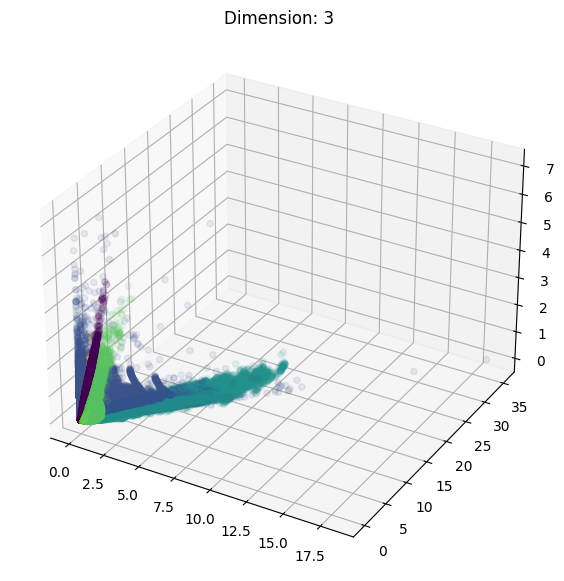

100%|██████████| 1/1 [02:56<00:00, 176.97s/it]

time: 2min 56s (started: 2023-05-18 20:43:15 -05:00)


In [43]:
# Plot join

for dimension in tqdm(dimensions):
    # Read dataset
    df_edge_embeddings_join = pd.read_csv("{}/output_{}/edge_embeddings_join/{}_edge-embeddings_join_{}_{}.csv".format(dir, method, group[0], dimension, "L2"), index_col=0)

    x = df_edge_embeddings_join.iloc[:, 0]
    y = df_edge_embeddings_join.iloc[:, 1]
    z = df_edge_embeddings_join.iloc[:, 2]

    # Creating figure
    fig = plt.figure(figsize = (10, 7))
    ax = plt.axes(projection ="3d")

    # Creating plot
    ax.scatter3D(x, y, z, c=df_edge_embeddings_join.iloc[:, -1], alpha=0.1)
    plt.title("Dimension: {}".format(dimension))

    # show plot
    plt.show()

### Clustering

In [44]:
# silhouette_score(X_train.iloc[:, :-1], X_train.iloc[:, -1])

time: 426 µs (started: 2023-05-18 20:46:12 -05:00)


In [45]:
# Outlier detection

for dimension in tqdm(dimensions):
    df_edge_embeddings_join = pd.read_csv("{}/output_{}/edge_embeddings_join/{}_edge-embeddings_join_{}_{}.csv".format(dir, method, group[0], dimension, "L2"), index_col=0)
    
    X_train = df_edge_embeddings_join.iloc[:, :-1]
    clusterer = hdbscan.HDBSCAN(min_cluster_size=100, core_dist_n_jobs=-1).fit(X_train)

100%|██████████| 1/1 [39:28<00:00, 2368.11s/it]

time: 39min 28s (started: 2023-05-18 20:46:13 -05:00)


In [46]:
threshold = pd.Series(clusterer.outlier_scores_).quantile(0.9)
outliers = np.where(clusterer.outlier_scores_ > threshold)[0]

print(len(outliers))
outliers

1223483


array([       1,        4,        5, ..., 12234777, 12234811, 12234817])

time: 22.8 s (started: 2023-05-18 21:25:41 -05:00)


Total: 12234830
Num. of outliers: 1223483
Num. of no-outliers: 10040701


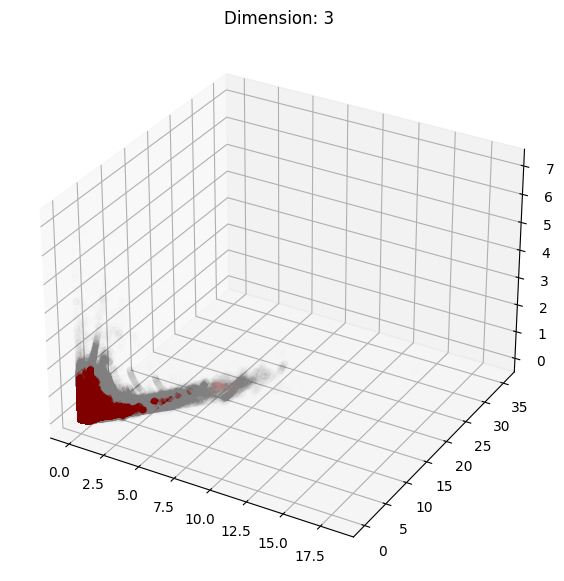

time: 2min 45s (started: 2023-05-18 21:26:04 -05:00)


In [47]:
print("Total:", len(df_edge_embeddings_join))
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

temp = df_edge_embeddings_join.iloc[outliers, :]
x = temp.iloc[:, 0]
y = temp.iloc[:, 1]
z = temp.iloc[:, 2]
ax.scatter3D(x, y, z, c="gray", alpha=0.005)
print("Num. of outliers:", len(temp))

temp = df_edge_embeddings_join.drop(df_edge_embeddings_join.index[outliers])
x = temp.iloc[:, 0]
y = temp.iloc[:, 1]
z = temp.iloc[:, 2]
ax.scatter3D(x, y, z, c="red", alpha=0.005)
print("Num. of no-outliers:", len(temp))

plt.title("Dimension: {}".format(dimension))
plt.show()

###  Filter common edges

In [48]:
df_edge_embeddings_join_filter = df_edge_embeddings_join.drop(df_edge_embeddings_join.index[outliers])
df_edge_embeddings_join_filter.to_csv("{}/output_{}/edges_filter/{}_edges-filter_{}_{}.csv".format(dir, method, group[0], 3, "L2"), index=True)
df_edge_embeddings_join_filter

,0,1,2,subgroup
"(0, 1)",0.001143,1.998090e-09,0.001940,1
"(0, 4)",0.000181,9.845161e-08,0.000326,1
"(1, 131)",0.005140,2.982356e-06,0.009269,1
"(1, 3180)",0.000024,1.552491e-04,0.000243,1
"(1, 3035)",0.000884,3.697820e-05,0.002442,1
...,...,...,...,...
"(6173, 6174)",0.004284,9.763920e-03,0.023304,5
"(6203, 6204)",0.020778,2.462862e-02,0.007201,5
"(6203, 6218)",0.061004,4.521981e-03,0.055079,5
"(6211, 6215)",0.029771,2.263489e-02,0.082082,5


time: 46 s (started: 2023-05-18 21:28:50 -05:00)


In [49]:
df_edge_embeddings_join_filter = pd.read_csv("{}/output_{}/edges_filter/{}_edges-filter_{}_{}.csv".format(dir, method, group[0], 3, "L2"), index_col=0)
df_edge_embeddings_join_filter.set_index([pd.Index([eval(item) for item in df_edge_embeddings_join_filter.index])], inplace=True)
df_edge_embeddings_join_filter.to_csv("{}/output_{}/edges_filter/{}_edges-filter_{}_{}.csv".format(dir, method, group[0], 3, "L2"), index=True)
df_edge_embeddings_join_filter

0             1         2  subgroup
0    1     0.001143  1.998090e-09  0.001940         1
     4     0.000181  9.845161e-08  0.000326         1
1    131   0.005140  2.982356e-06  0.009269         1
     3180  0.000024  1.552491e-04  0.000243         1
     3035  0.000884  3.697820e-05  0.002442         1
...             ...           ...       ...       ...
6173 6174  0.004284  9.763920e-03  0.023304         5
6203 6204  0.020778  2.462862e-02  0.007201         5
     6218  0.061004  4.521981e-03  0.055079         5
6211 6215  0.029771  2.263489e-02  0.082082         5
     6219  0.066507  3.380889e-02  0.141371         5

[10040701 rows x 4 columns]

time: 1min 48s (started: 2023-05-18 21:29:36 -05:00)


In [50]:
df_edge_embeddings_join_filter = pd.read_csv("{}/output_{}/edges_filter/{}_edges-filter_{}_{}.csv".format(dir, method, group[0], 3, "L2"), index_col=[0, 1])
df_edge_embeddings_join_filter

0             1         2  subgroup
0    1     0.001143  1.998090e-09  0.001940         1
     4     0.000181  9.845161e-08  0.000326         1
1    131   0.005140  2.982356e-06  0.009269         1
     3180  0.000024  1.552491e-04  0.000243         1
     3035  0.000884  3.697820e-05  0.002442         1
...             ...           ...       ...       ...
6173 6174  0.004284  9.763920e-03  0.023304         5
6203 6204  0.020778  2.462862e-02  0.007201         5
     6218  0.061004  4.521981e-03  0.055079         5
6211 6215  0.029771  2.263489e-02  0.082082         5
     6219  0.066507  3.380889e-02  0.141371         5

[10040701 rows x 4 columns]

time: 3.92 s (started: 2023-05-18 21:31:25 -05:00)


In [51]:
df_nodes = pd.read_csv("{}/output_preprocessing/graph_data/{}_nodes_data_{}.csv".format(dir, group[0], 1))
df_nodes

,idx,degree,ionMz
0,0,10,59.0049
1,1,25,274.0123
2,2,64,277.0867
3,3,60,369.1213
4,4,69,369.1541
...,...,...,...
6229,6229,1,818.2612
6230,6230,1,807.9051
6231,6231,2,995.9381
6232,6232,2,939.1026


time: 15.5 ms (started: 2023-05-18 21:31:29 -05:00)


In [52]:
# Mapping idx with ionMz
dict_df_nodes = {}
list_index = []
for i in tqdm(subgroups):
    df_nodes = pd.read_csv("{}/output_preprocessing/graph_data/{}_nodes_data_{}.csv".format(dir, group[0], i))
    dict_df_nodes[i] = df_nodes

for dimension in tqdm(dimensions):
    df_edge_embeddings_join_filter = pd.read_csv("{}/output_{}/edges_filter/{}_edges-filter_{}_{}.csv".format(dir, method, group[0], 3, "L2"), index_col=[0, 1])

    for row in df_edge_embeddings_join_filter.itertuples():
        df_nodes = dict_df_nodes[str(row[-1])]        
        list_index.append((df_nodes.iloc[row[0][0], -1], df_nodes.iloc[row[0][1], -1]))

100%|██████████| 1/1 [04:26<00:00, 266.88s/it]

time: 4min 27s (started: 2023-05-18 21:31:29 -05:00)


In [53]:
# Set new index
df_edge_embeddings_join_filter.set_index([pd.Index(list_index)], inplace=True)
df_edge_embeddings_join_filter

0             1         2  subgroup
59.0049  274.0123  0.001143  1.998090e-09  0.001940         1
         369.1541  0.000181  9.845161e-08  0.000326         1
274.0123 191.0460  0.005140  2.982356e-06  0.009269         1
         198.0748  0.000024  1.552491e-04  0.000243         1
         201.0761  0.000884  3.697820e-05  0.002442         1
...                     ...           ...       ...       ...
979.9144 980.1544  0.004284  9.763920e-03  0.023304         5
734.2528 940.2058  0.020778  2.462862e-02  0.007201         5
         991.3236  0.061004  4.521981e-03  0.055079         5
735.2385 732.2616  0.029771  2.263489e-02  0.082082         5
         914.1092  0.066507  3.380889e-02  0.141371         5

[10040701 rows x 4 columns]

time: 3.93 s (started: 2023-05-18 21:35:57 -05:00)


In [54]:
# Count
temp = df_edge_embeddings_join_filter.index.value_counts().to_frame()
df_edge_embeddings_join_filter_count = temp[temp["count"] == len(subgroups)]
df_edge_embeddings_join_filter_count.to_csv("{}/output_{}/edges_filter/{}_edges-filter-count_{}_{}.csv".format(dir, method, group[0], dimension, "L2"), index=True)
df_edge_embeddings_join_filter_count

,,count
245.1144,503.1803,5
267.0740,420.0814,5
835.6000,964.5305,5
717.5658,818.6501,5
282.1572,517.0546,5
...,...,...
688.4907,900.5356,5
645.4494,906.4804,5
218.1033,542.1698,5
689.4951,962.5375,5


time: 2.59 s (started: 2023-05-18 21:36:01 -05:00)


In [55]:
df_edge_embeddings_join_filter_count = pd.read_csv("{}/output_{}/edges_filter/{}_edges-filter-count_{}_{}.csv".format(dir, method, group[0], 3, "L2"))
df_edge_embeddings_join_filter_count.columns = ["source", "target", "count"]
# print(df_edge_embeddings_join_filter_count.info())
df_edge_embeddings_join_filter_count

,source,target,count
0,245.1144,503.1803,5
1,267.0740,420.0814,5
2,835.6000,964.5305,5
3,717.5658,818.6501,5
4,282.1572,517.0546,5
...,...,...,...
11185,688.4907,900.5356,5
11186,645.4494,906.4804,5
11187,218.1033,542.1698,5
11188,689.4951,962.5375,5


time: 17 ms (started: 2023-05-18 21:36:03 -05:00)


In [56]:
df_edges = pd.read_csv("{}/output_preprocessing/edges/{}_edges_{}.csv".format(dir, group[0], 2))
# print(df_edges.info())
df_edges

,source,target,weight
0,59.0049,59.0291,0.541623
1,59.0049,59.0370,0.553259
2,59.0049,164.0963,0.527691
3,59.0049,306.8897,0.538185
4,59.0049,405.2949,0.549859
...,...,...,...
939033,988.5664,996.7096,0.530655
939034,988.8558,998.4845,0.565444
939035,989.4484,989.5686,0.624192
939036,990.3213,990.4534,0.747188


time: 423 ms (started: 2023-05-18 21:36:03 -05:00)


In [57]:
# Get weight
df_edge_embeddings_join_filter_count_weight = df_edge_embeddings_join_filter_count.copy()
s = []
t = []
for row in df_edge_embeddings_join_filter_count_weight.itertuples():
    if row[1] > row[2]:
        s.append(row[2])
        t.append(row[1])
    else:
        s.append(row[1])
        t.append(row[2])
df_edge_embeddings_join_filter_count_weight["source"] = s
df_edge_embeddings_join_filter_count_weight["target"] = t

# df_edge_embeddings_join_filter_count_weight = df_edge_embeddings_join_filter_count.copy()
df_edge_embeddings_join_filter_count_weight.sort_values(["source", "target"], ascending=True, inplace=True)
df_edge_embeddings_join_filter_count_weight["idx"] = df_edge_embeddings_join_filter_count_weight["source"].astype(str) + "-" + df_edge_embeddings_join_filter_count_weight["target"].astype(str)
list_aux = df_edge_embeddings_join_filter_count_weight.iloc[:, -1].values

for i in tqdm(subgroups):
    df_edges = pd.read_csv("{}/output_preprocessing/edges/{}_edges_{}.csv".format(dir, group[0], i))
    df_edges.sort_values(["source", "target"], ascending=True, inplace=True)
    df_edges["idx"] = df_edges["source"].astype(str) + "-" + df_edges["target"].astype(str)

    """ list_temp = []
    # for j in tqdm(range(len(df_edges_filter_count_weight))):
    for row in tqdm(df_edge_embeddings_join_filter_count_weight.itertuples()):
        # weight = 1 # df_edges[(df_edges["source"] == row[1]) & (df_edges["target"] == row[2])].iloc[0, -1]
        weight = df_edges[df_edges["idx"] == "{}-{}".format(row[1], row[2])].iloc[0, -2]
        list_temp.append(weight) """
    
    filter = df_edges["idx"].isin(list_aux)
    temp = df_edges[filter]
    list_temp = temp.iloc[:, -2].values
    df_edge_embeddings_join_filter_count_weight["subgroup{}".format(i)] = list_temp
df_edge_embeddings_join_filter_count_weight


100%|██████████| 5/5 [00:19<00:00,  3.81s/it]


,source,target,count,idx,subgroup1,subgroup2,subgroup3,subgroup4,subgroup5
9441,59.0137,389.3284,5,59.0137-389.3284,0.861323,0.889178,0.521535,0.795494,0.890928
9445,59.0137,391.2964,5,59.0137-391.2964,0.884855,0.881009,0.675525,0.779375,0.913434
9301,59.0137,418.3254,5,59.0137-418.3254,0.917996,0.948796,0.786776,0.798094,0.938164
9304,59.0137,419.3285,5,59.0137-419.3285,0.890301,0.924668,0.508142,0.749985,0.880726
8087,59.0291,391.2964,5,59.0291-391.2964,0.815696,0.757921,0.524640,0.510577,0.897781
...,...,...,...,...,...,...,...,...,...
6563,952.6839,974.4786,5,952.6839-974.4786,0.532269,0.514822,0.760739,0.780408,0.743764
4945,953.5061,995.4648,5,953.5061-995.4648,0.555360,0.594169,0.709739,0.699470,0.772365
1459,953.6866,978.5819,5,953.6866-978.5819,0.746251,0.563436,0.548912,0.685509,0.836411
9318,969.6816,979.5239,5,969.6816-979.5239,0.931934,0.819327,0.712098,0.879674,0.939396


time: 19.1 s (started: 2023-05-18 21:36:04 -05:00)


In [ ]:
# df_edges = pd.read_csv("{}/output_preprocessing/edges/{}_edges_{}.csv".format(dir, group[0], 2))
# df_edges[(df_edges["source"] == 986.7752) & (df_edges["target"] == 989.4484)].iloc[0, -1]

In [59]:
# Dispersion (std)
df_edge_embeddings_join_filter_count_weight_std = df_edge_embeddings_join_filter_count_weight.copy()
df_edge_embeddings_join_filter_count_weight_std["std"] = np.std(df_edge_embeddings_join_filter_count_weight_std.iloc[:, -len(subgroups):], axis=1)
df_edge_embeddings_join_filter_count_weight_std

,source,target,count,idx,subgroup1,subgroup2,subgroup3,subgroup4,subgroup5,std
9441,59.0137,389.3284,5,59.0137-389.3284,0.861323,0.889178,0.521535,0.795494,0.890928,0.139427
9445,59.0137,391.2964,5,59.0137-391.2964,0.884855,0.881009,0.675525,0.779375,0.913434,0.088258
9301,59.0137,418.3254,5,59.0137-418.3254,0.917996,0.948796,0.786776,0.798094,0.938164,0.070623
9304,59.0137,419.3285,5,59.0137-419.3285,0.890301,0.924668,0.508142,0.749985,0.880726,0.153277
8087,59.0291,391.2964,5,59.0291-391.2964,0.815696,0.757921,0.524640,0.510577,0.897781,0.156513
...,...,...,...,...,...,...,...,...,...,...
6563,952.6839,974.4786,5,952.6839-974.4786,0.532269,0.514822,0.760739,0.780408,0.743764,0.117346
4945,953.5061,995.4648,5,953.5061-995.4648,0.555360,0.594169,0.709739,0.699470,0.772365,0.079684
1459,953.6866,978.5819,5,953.6866-978.5819,0.746251,0.563436,0.548912,0.685509,0.836411,0.109160
9318,969.6816,979.5239,5,969.6816-979.5239,0.931934,0.819327,0.712098,0.879674,0.939396,0.084063


time: 25.3 ms (started: 2023-05-18 21:36:54 -05:00)


In [60]:
# Filter by std
df_edge_embeddings_join_filter_count_weight_std = df_edge_embeddings_join_filter_count_weight_std[df_edge_embeddings_join_filter_count_weight_std["std"] <= 0.3]
df_edge_embeddings_join_filter_count_weight_std.to_csv("{}/output_{}/edges_filter_weight_std/{}_edge-filter-weight-std_{}_{}.csv".format(dir, method, group[0], dimension, "L2"), index=False)
df_edge_embeddings_join_filter_count_weight_std

,source,target,count,idx,subgroup1,subgroup2,subgroup3,subgroup4,subgroup5,std
9441,59.0137,389.3284,5,59.0137-389.3284,0.861323,0.889178,0.521535,0.795494,0.890928,0.139427
9445,59.0137,391.2964,5,59.0137-391.2964,0.884855,0.881009,0.675525,0.779375,0.913434,0.088258
9301,59.0137,418.3254,5,59.0137-418.3254,0.917996,0.948796,0.786776,0.798094,0.938164,0.070623
9304,59.0137,419.3285,5,59.0137-419.3285,0.890301,0.924668,0.508142,0.749985,0.880726,0.153277
8087,59.0291,391.2964,5,59.0291-391.2964,0.815696,0.757921,0.524640,0.510577,0.897781,0.156513
...,...,...,...,...,...,...,...,...,...,...
6563,952.6839,974.4786,5,952.6839-974.4786,0.532269,0.514822,0.760739,0.780408,0.743764,0.117346
4945,953.5061,995.4648,5,953.5061-995.4648,0.555360,0.594169,0.709739,0.699470,0.772365,0.079684
1459,953.6866,978.5819,5,953.6866-978.5819,0.746251,0.563436,0.548912,0.685509,0.836411,0.109160
9318,969.6816,979.5239,5,969.6816-979.5239,0.931934,0.819327,0.712098,0.879674,0.939396,0.084063


time: 125 ms (started: 2023-05-18 21:37:05 -05:00)


In [61]:
df_edge_embeddings_join_filter_count_weight_std = pd.read_csv("{}/output_{}/edges_filter_weight_std/{}_edge-filter-weight-std_{}_{}.csv".format(dir, method, group[0], dimension, "L2"))
df_edge_embeddings_join_filter_count_weight_std

,source,target,count,idx,subgroup1,subgroup2,subgroup3,subgroup4,subgroup5,std
0,59.0137,389.3284,5,59.0137-389.3284,0.861323,0.889178,0.521535,0.795494,0.890928,0.139427
1,59.0137,391.2964,5,59.0137-391.2964,0.884855,0.881009,0.675525,0.779375,0.913434,0.088258
2,59.0137,418.3254,5,59.0137-418.3254,0.917996,0.948796,0.786776,0.798094,0.938164,0.070623
3,59.0137,419.3285,5,59.0137-419.3285,0.890301,0.924668,0.508142,0.749985,0.880726,0.153277
4,59.0291,391.2964,5,59.0291-391.2964,0.815696,0.757921,0.524640,0.510577,0.897781,0.156513
...,...,...,...,...,...,...,...,...,...,...
11081,952.6839,974.4786,5,952.6839-974.4786,0.532269,0.514822,0.760739,0.780408,0.743764,0.117346
11082,953.5061,995.4648,5,953.5061-995.4648,0.555360,0.594169,0.709739,0.699470,0.772365,0.079684
11083,953.6866,978.5819,5,953.6866-978.5819,0.746251,0.563436,0.548912,0.685509,0.836411,0.109160
11084,969.6816,979.5239,5,969.6816-979.5239,0.931934,0.819327,0.712098,0.879674,0.939396,0.084063


time: 33.3 ms (started: 2023-05-18 21:37:13 -05:00)


In [62]:
# Average weight
df_edge_embeddings_join_filter_count_weight_std_avg = df_edge_embeddings_join_filter_count_weight_std.copy()
df_edge_embeddings_join_filter_count_weight_std_avg["weight"] = df_edge_embeddings_join_filter_count_weight_std_avg.iloc[:, -(len(subgroups) + 1):-1].mean(axis=1)
df_edge_embeddings_join_filter_count_weight_std_avg

,source,target,count,idx,subgroup1,subgroup2,subgroup3,subgroup4,subgroup5,std,weight
0,59.0137,389.3284,5,59.0137-389.3284,0.861323,0.889178,0.521535,0.795494,0.890928,0.139427,0.791692
1,59.0137,391.2964,5,59.0137-391.2964,0.884855,0.881009,0.675525,0.779375,0.913434,0.088258,0.826840
2,59.0137,418.3254,5,59.0137-418.3254,0.917996,0.948796,0.786776,0.798094,0.938164,0.070623,0.877965
3,59.0137,419.3285,5,59.0137-419.3285,0.890301,0.924668,0.508142,0.749985,0.880726,0.153277,0.790765
4,59.0291,391.2964,5,59.0291-391.2964,0.815696,0.757921,0.524640,0.510577,0.897781,0.156513,0.701323
...,...,...,...,...,...,...,...,...,...,...,...
11081,952.6839,974.4786,5,952.6839-974.4786,0.532269,0.514822,0.760739,0.780408,0.743764,0.117346,0.666400
11082,953.5061,995.4648,5,953.5061-995.4648,0.555360,0.594169,0.709739,0.699470,0.772365,0.079684,0.666221
11083,953.6866,978.5819,5,953.6866-978.5819,0.746251,0.563436,0.548912,0.685509,0.836411,0.109160,0.676104
11084,969.6816,979.5239,5,969.6816-979.5239,0.931934,0.819327,0.712098,0.879674,0.939396,0.084063,0.856486


time: 16.5 ms (started: 2023-05-18 21:37:19 -05:00)


In [63]:
df_edge_embeddings_join_filter_count_weight_std_avg = df_edge_embeddings_join_filter_count_weight_std_avg.iloc[:, [0, 1, -1]]
df_edge_embeddings_join_filter_count_weight_std_avg.to_csv("{}/output_{}/edges_filter_weight_std_avg/{}_edge-filter-weight-std-avg_{}_{}.csv".format(dir, method, group[0], dimension, "L2"), index=False)
df_edge_embeddings_join_filter_count_weight_std_avg

,source,target,weight
0,59.0137,389.3284,0.791692
1,59.0137,391.2964,0.826840
2,59.0137,418.3254,0.877965
3,59.0137,419.3285,0.790765
4,59.0291,391.2964,0.701323
...,...,...,...
11081,952.6839,974.4786,0.666400
11082,953.5061,995.4648,0.666221
11083,953.6866,978.5819,0.676104
11084,969.6816,979.5239,0.856486


time: 50.3 ms (started: 2023-05-18 21:37:29 -05:00)


In [64]:
df_edge_embeddings_join_filter_count_weight_std_avg = pd.read_csv("{}/output_{}/edges_filter_weight_std_avg/{}_edge-filter-weight-std-avg_{}_{}.csv".format(dir, method, group[0], dimension, "L2"))
df_edge_embeddings_join_filter_count_weight_std_avg

,source,target,weight
0,59.0137,389.3284,0.791692
1,59.0137,391.2964,0.826840
2,59.0137,418.3254,0.877965
3,59.0137,419.3285,0.790765
4,59.0291,391.2964,0.701323
...,...,...,...
11081,952.6839,974.4786,0.666400
11082,953.5061,995.4648,0.666221
11083,953.6866,978.5819,0.676104
11084,969.6816,979.5239,0.856486


time: 19.3 ms (started: 2023-05-18 21:37:36 -05:00)
